In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import cv2
import random
from skimage.transform import rotate, resize

In [2]:
def preprocess_roi(roi):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    eq = cv2.equalizeHist(gray)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY, blockSize=23, C=5)
    return eq, thresh

In [3]:
def compute_fitness(template_img, eq_img, bin_img, tx, ty, sx, sy, theta):
    h, w = template_img.shape[:2]
    th, tw = int(h * sy), int(w * sx)

    temp = resize(template_img, (th, tw), anti_aliasing=True)
    temp = rotate(temp, theta, resize=False)
    temp = (temp * 255).astype(np.uint8)

    roi_h, roi_w = eq_img.shape
    if tx + tw > roi_w or ty + th > roi_h:
        return 0

    eq_crop = eq_img[ty:ty+th, tx:tx+tw]
    bin_crop = bin_img[ty:ty+th, tx:tx+tw]

    third = th // 3
    if third == 0: return 0

    a = np.mean(eq_crop[0:third])
    b = np.mean(eq_crop[third:2*third])
    c = np.mean(eq_crop[2*third:])

    r1 = abs(a - b)
    r2 = abs(c - b)
    O1 = (r1 + r2) / 2

    awht = np.sum(bin_crop[0:third] == 255) / (bin_crop[0:third].size + 1e-5)
    bblk = np.sum(bin_crop[third:2*third] == 0) / (bin_crop[third:2*third].size + 1e-5)
    cwht = np.sum(bin_crop[2*third:] == 255) / (bin_crop[2*third:].size + 1e-5)

    O2 = (awht + cwht + 2 * bblk) / 4
    return O1 + O2  # Total fitness

In [4]:
def run_ga(template, eq_img, bin_img, img_size, pop_size=50, gen_size=50):
    wtgt, htgt = img_size
    population = [(
        random.randint(0, wtgt - 46),  # tx
        random.randint(0, htgt - 18),  # ty
        random.uniform(0.8, 1.2),      # sx
        random.uniform(0.8, 1.2),      # sy
        random.uniform(-30, 0)         # θ
    ) for _ in range(pop_size)]

    best_ind = None
    best_fit = -1

    for gen in range(gen_size):
        fitnesses = []
        for ind in population:
            tx, ty, sx, sy, theta = ind
            f = compute_fitness(template, eq_img, bin_img, tx, ty, sx, sy, theta)
            fitnesses.append(f)
            if f > best_fit:
                best_fit = f
                best_ind = ind

        # Selection (top 20%)
        parents = [population[i] for i in np.argsort(fitnesses)[-pop_size//5:]]

        # Crossover + Mutation
        new_population = []
        while len(new_population) < pop_size:
            p1, p2 = random.sample(parents, 2)
            child = (
                random.choice([p1[0], p2[0]]),  # tx
                random.choice([p1[1], p2[1]]),  # ty
                (p1[2] + p2[2]) / 2,            # sx
                (p1[3] + p2[3]) / 2,            # sy
                (p1[4] + p2[4]) / 2             # θ
            )
            # Mutation
            if random.random() < 0.1:
                child = (
                    child[0] + random.randint(-5, 5),
                    child[1] + random.randint(-5, 5),
                    child[2] * random.uniform(0.95, 1.05),
                    child[3] * random.uniform(0.95, 1.05),
                    child[4] + random.uniform(-2, 2)
                )
            new_population.append(child)

        population = new_population

    return best_ind, best_fit

In [10]:
template = cv2.imread("template.jpg")
test_img = cv2.imread("/content/content/cropped_rois/test/1625227980342_jpg.rf.8aca4bf1711f1a65c7ba8083cf7e7519_windshield_2.jpg")
eq_img, bin_img = preprocess_roi(test_img)

best_params, score = run_ga(template, eq_img, bin_img, img_size=eq_img.shape[::-1])
print("Best Match:", best_params, "Fitness:", score)

Best Match: (27, 10, 0.7871572221642266, 1.026103877644115, -18.666483460518602) Fitness: 98.58564812221366


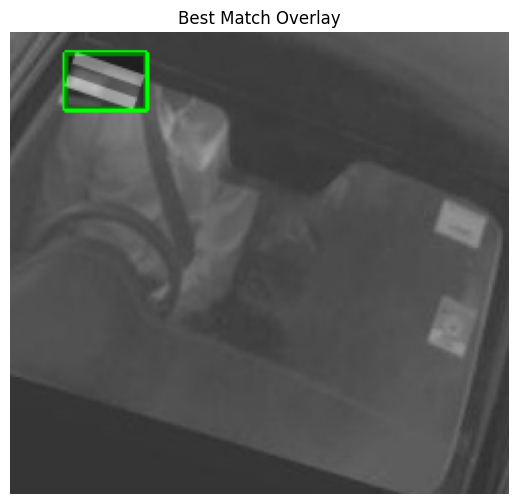

In [12]:

import cv2
import numpy as np
from skimage.transform import rotate, resize
import matplotlib.pyplot as plt

def overlay_template_on_image(test_image, template_image, tx, ty, sx, sy, theta):

    th, tw = template_image.shape[:2]
    new_h, new_w = int(th * sy), int(tw * sx)

    resized_template = resize(template_image, (new_h, new_w), anti_aliasing=True)
    rotated_template = rotate(resized_template, theta, resize=True)
    rotated_template = (rotated_template * 255).astype(np.uint8)


    if len(rotated_template.shape) == 2:
        rotated_template = cv2.cvtColor(rotated_template, cv2.COLOR_GRAY2BGR)


    overlay = test_image.copy()

    h, w = rotated_template.shape[:2]


    if tx + w > overlay.shape[1] or ty + h > overlay.shape[0]:
        print("⚠️ Template goes out of bounds. Adjust tx, ty or scale.")
        return


    cv2.rectangle(overlay, (tx, ty), (tx + w, ty + h), (0, 255, 0), 2)


    roi = overlay[ty:ty+h, tx:tx+w]
    blended = cv2.addWeighted(roi, 0.5, rotated_template, 0.5, 0)
    overlay[ty:ty+h, tx:tx+w] = blended


    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Best Match Overlay")
    plt.axis("off")
    plt.show()


template_path = "template.jpg"
test_image_path = "/content/content/cropped_rois/test/1625227980342_jpg.rf.8aca4bf1711f1a65c7ba8083cf7e7519_windshield_2.jpg"

template = cv2.imread(template_path)
test_img = cv2.imread(test_image_path)


tx, ty = 27, 10
sx, sy = 0.787, 1.026
theta = -18.666

overlay_template_on_image(test_img, template, tx, ty, sx, sy, theta)
